In [6]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]



In [7]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, parmas, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [8]:
#학습률에 따라 수렴성과 발산정도가 달라진다. 
#매개변수 h를 통해 이를 해결 하지만 h가 점점 정체 되는 현상 발생 이를 해결하기 위해 지수이동평균 도입 

class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key])+ 1e-7)
        

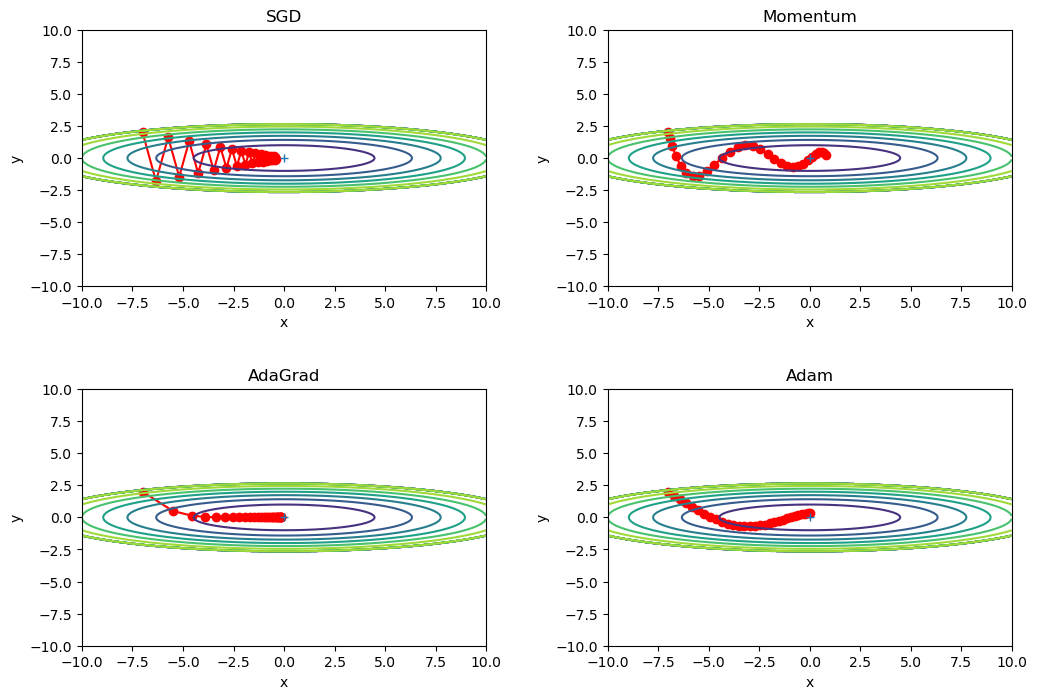

In [9]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

plt.figure(figsize=(12, 8))

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.subplots_adjust(wspace=0.3, hspace=0.4)    
plt.show()

===========iteration:0===========
SGD:2.343872901109396
Momentum:2.3188148743523467
AdaGrad:2.1132748840528746
Adam:2.1973332672516825
===========iteration:100===========
SGD:1.5890908348515094
Momentum:0.30921237914868194
AdaGrad:0.0843755001368387
Adam:0.2207916323250003
===========iteration:200===========
SGD:0.8015173073009746
Momentum:0.19005786947487663
AdaGrad:0.05844585847670866
Adam:0.1283678501864781
===========iteration:300===========
SGD:0.586331374586121
Momentum:0.1917080210904181
AdaGrad:0.11038255499489279
Adam:0.1296994284197308
===========iteration:400===========
SGD:0.3742608022950397
Momentum:0.19150425326097467
AdaGrad:0.10424528374818103
Adam:0.17524006225450772
===========iteration:500===========
SGD:0.5037434254954771
Momentum:0.18788434026532375
AdaGrad:0.0931812004606421
Adam:0.12007156734087551
===========iteration:600===========
SGD:0.19254732133964406
Momentum:0.07806908267037231
AdaGrad:0.024803398453854035
Adam:0.056850598953596315
===========iteration:70

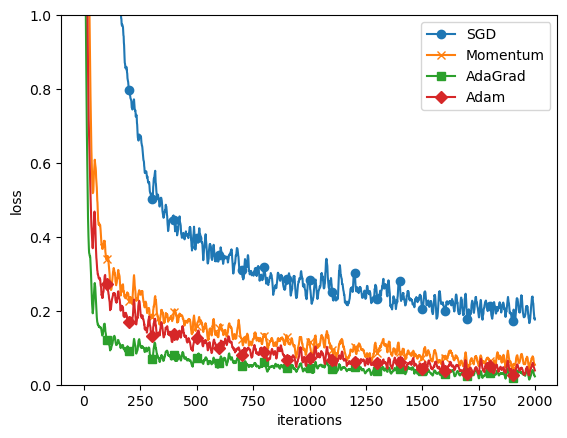

In [11]:
import sys, os
sys.path.append(os.pardir)

import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [13]:
import numpy as np 
import matplotlib.pyplot as plt 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) #1000개의 데이터 
node_num = 100 #각 은닉층의 뉴런의 수 
hidden_layer_size = 5 #은닉층이 5개 
activations = {} #이곳에 활성화 값을 저장 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    

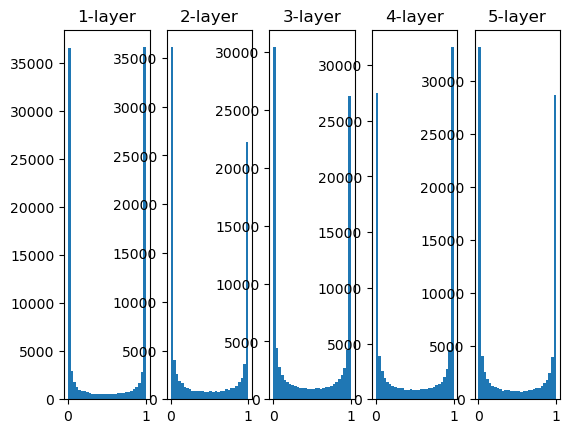

In [17]:
for i, a in activations.items():
    
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()

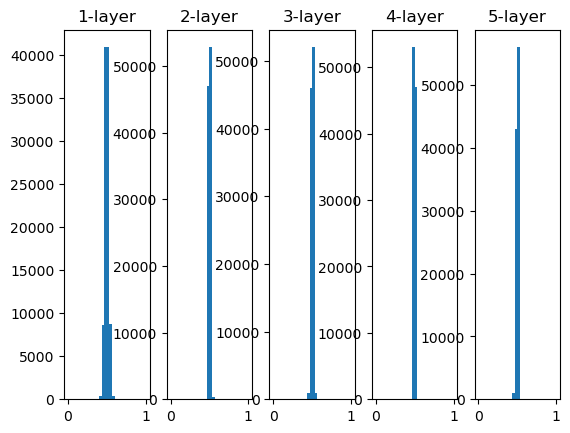

In [18]:
x = np.random.randn(1000, 100) #1000개의 데이터 
node_num = 100 #각 은닉층의 뉴런의 수 
hidden_layer_size = 5 #은닉층이 5개 
activations = {} #이곳에 활성화 값을 저장 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
for i, a in activations.items():
    
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()  

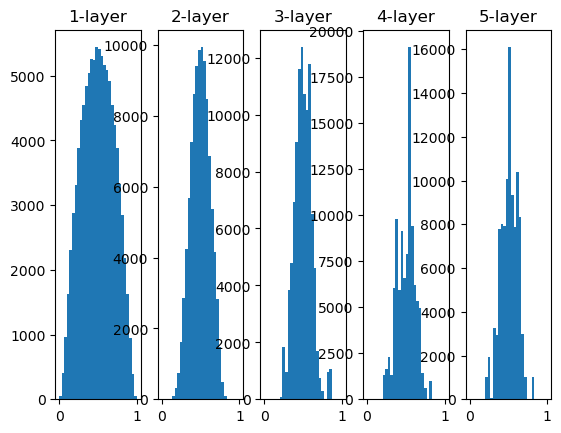

In [19]:
x = np.random.randn(1000, 100) #1000개의 데이터 
node_num = 100 #각 은닉층의 뉴런의 수 
hidden_layer_size = 5 #은닉층이 5개 
activations = {} #이곳에 활성화 값을 저장 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) /np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
for i, a in activations.items():
    
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()  

===========iteration:0===========
std=0.01:2.302443654466374
Xavier:2.3089802988016657
He:2.282087106445374
===========iteration:100===========
std=0.01:2.302919489380454
Xavier:2.248451325639115
He:1.3890796412453923
===========iteration:200===========
std=0.01:2.3015148225498003
Xavier:2.1451767206467878
He:0.6359700302818654
===========iteration:300===========
std=0.01:2.3030339557055113
Xavier:1.8462805705889729
He:0.5422037956406269
===========iteration:400===========
std=0.01:2.3026891584050664
Xavier:1.3378295535608955
He:0.44311707752034
===========iteration:500===========
std=0.01:2.304597801385473
Xavier:0.9892787193747331
He:0.459393028611502
===========iteration:600===========
std=0.01:2.3026193368570205
Xavier:0.777399813688864
He:0.38127320049474367
===========iteration:700===========
std=0.01:2.2966607203680054
Xavier:0.4904984606741223
He:0.2664363639668723
===========iteration:800===========
std=0.01:2.3015329709093093
Xavier:0.44757254204840735
He:0.26437759223752444


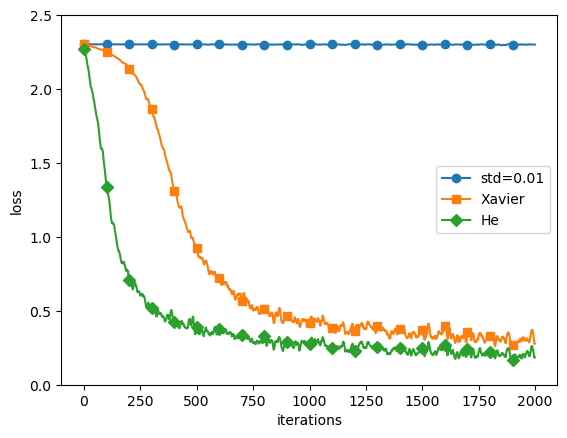

In [20]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

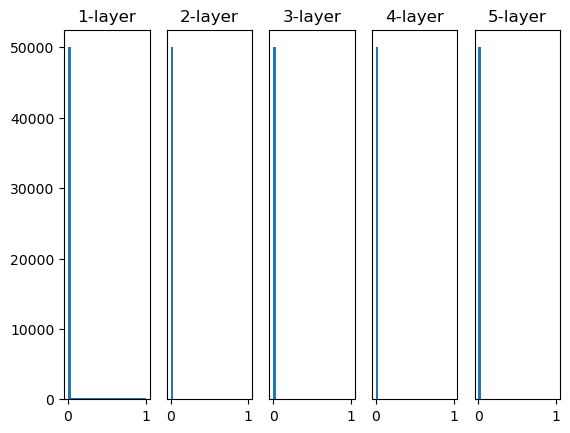

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()